In [1]:
%reload_ext autoreload
%autoreload 2

# Arquitecturas Preentrenadas. Opción A. Clasificación de textos con redes preentrenadas

El objetivo de este notebook es implementar un enfoque que combine el uso de embeddings preentrenados y modelos de machine learning clásicos para la clasificación de textos. En primer lugar, se utiliza el modelo preentrenado `paraphrase-albert-small-v2` para codificar las reseñas en embeddings densos. Estos embeddings se emplearán como características de entrada en modelos clásicos de clasificación, en este caso Random Forest y XGBoost, con el objetivo de predecir la calificación de las recomendaciones.

Se evaluarán los resultados de estos dos modelos utilizando la muestra de validación disponible y se compararán con los resultados obtenidos con la arquitectura diseñada previamente. El análisis comparativo permitirá determinar qué modelo es más adecuado para este caso de uso. Finalmente, el modelo seleccionado se utilizará para predecir las calificaciones de las reseñas en el archivo `new_data.txt`.

Se procede a cargar las librerías en el entorno

In [16]:
from pathlib import Path

import joblib
import optuna
import pandas as pd
import numpy as np
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sentence_transformers import SentenceTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, f1_score, make_scorer, 
                             precision_score, recall_score)
from sklearn.model_selection import (RepeatedStratifiedKFold, 
                                     cross_val_predict, cross_val_score, 
                                     train_test_split)
import xgboost as xgb

from transf.paths import DATA_DIR, MODELS_DIR
from transf.preprocessing import (clean_text, plot_confusion_matrix,
                                   plot_roc_curve)
import transf.config as cfg

Se carga un modelo preentrenado de embeddings, paraphrase-albert-small-v2, que se usará para transformar las reseñas en vectores de características numéricas. Asimimso, se define una estrategia de validación cruzada estratificada y repetida, que asegura que la proporción de clases se mantenga constante para obtener una estimación robusta del rendimiento. Finalmente, se crea un scorer personalizado basado en el F1-score, que puede ajustarse para utilizar diferentes umbrales de decisión en la clasificación, permitiendo medir la calidad del modelo en función de esta métrica como se hizo en el caso anterior.

In [3]:
# Load the pre-trained model
model = SentenceTransformer('paraphrase-albert-small-v2')

# Define the cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits=cfg.N_SPLITS, n_repeats=cfg.N_REPEATS, random_state=cfg.SEED)

# Custom scorer for F1-score with decision threshold (if needed)
f1_scorer = make_scorer(f1_score)

2024-09-11 22:38:13,686 - INFO - Use pytorch device_name: mps
2024-09-11 22:38:13,686 - INFO - Load pretrained SentenceTransformer: paraphrase-albert-small-v2
/Users/borja/Library/Caches/pypoetry/virtualenvs/class-trans-piHGrwZJ-py3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Se cargan los datos de la carpeta existente

In [4]:
# Load data
data_files = ['historical_data.csv', 'new_data.csv']
data, new_data = [pd.read_csv(DATA_DIR / file) for file in data_files]

Como se realizó anteriormente se cargan las palabras negativas con el fin de poder valorar mejor el sentimiento de una frase detemrinada.

In [5]:
# Load from the text file negations
with open(Path(DATA_DIR / 'negations.txt'), 'r') as file:
    negations = [line.strip() for line in file]

Se procede a una limpieza básica del texto tanto de entrenamiento como final

In [6]:
# Rename the columns and clean the text
data = (
    data
    .rename(columns={'Recommended.IND': 'recommended', 'Review.Text': 'review'})
    .assign(cleaned_review=lambda df: df['review'].apply(lambda x: clean_text(x, negations)))
)

# Apply the cleaning function to the review text columns and create new cleaned columns
new_data = (
    new_data
    .assign(cleaned_review=lambda df: df['Review.Text'].apply(lambda x: clean_text(x, negations)))
)

Se definen los sets de entrenamiento y de validación además de convertir en listas los textos obtenidos.

In [7]:
# Define X and y variables
X = data.drop(columns=['recommended', 'review'])
y = data['recommended']

# Split the data into training and validation sets and extract cleaned reviews
X_train_reviews, X_val_reviews, y_train, y_val = train_test_split(
    X['cleaned_review'].tolist(), 
    y, 
    test_size=cfg.VALIDATION_SPLIT, 
    stratify=y,
    random_state=cfg.SEED)

Una ve separado el texto se convierten las recomendaciones de texto en embeddings numéricos utilizando el modelo preentrenado. Cada conjunto de recomendaciones (tanto de entrenamiento como de validación) se transforma en una representación numérica vectorial. Estos embeddings capturan el significado semántico y se utilizarán como entradas para los modelos de machine learning clásicos que se utilizarán para clasificación binaria.

In [8]:
# Encode the reviews
X_train_embeddings, X_val_embeddings = [model.encode(reviews) for reviews in [X_train_reviews, X_val_reviews]]

Batches:   0%|          | 0/113 [00:00<?, ?it/s]

Batches:   0%|          | 0/29 [00:00<?, ?it/s]

Se define la optimización de hiperparámetros para un modelo Random Forest. Se configuran los como el número de árboles, la profundidad máxima de los árboles y la estrategia para manejar el desbalance de clases. A través de un pipeline que incluye la técnica SMOTE para el sobremuestreo de la clase minoritaria. Se evalúa el rendimiento del modelo utilizando validación cruzada y el F1-score como métrica principal al igul que se hizo con la red neuronal en el caso anterior.

In [9]:
# define the objective function for the Random Forest classifier
def objective_rf(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'max_depth': trial.suggest_int('max_depth', 3, 50),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample'])
    }
    pipeline = ImbPipeline([
        ('smoteenn', SMOTE(sampling_strategy='minority')),
        ('classifier', RandomForestClassifier(**param))
    ])
    cv_scores = cross_val_score(pipeline, X_train_embeddings, y_train, cv=cv, scoring=f1_scorer, n_jobs=-1)
    return cv_scores.mean()

Se crea el estudio que maximize el score elegido a través de 10 pruebas que se realoarán en paralelo.

In [10]:
# Create a study object, optimize the objective function with parallelization, and print the best hyperparameters and score
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=10, n_jobs=-1)

# Print the best hyperparameters and score
print(f'Best hyperparameters for Random Forest: {study_rf.best_params}\nBest score for Random Forest: {study_rf.best_value}')

[I 2024-09-10 01:22:13,741] A new study created in memory with name: no-name-69509271-31dc-47f9-bf26-4c998fc8d57f
[I 2024-09-10 02:06:12,192] Trial 3 finished with value: 0.9081167281810609 and parameters: {'n_estimators': 2853, 'max_depth': 34, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 3 with value: 0.9081167281810609.
[I 2024-09-10 05:55:35,955] Trial 6 finished with value: 0.8997331456637452 and parameters: {'n_estimators': 2035, 'max_depth': 25, 'max_features': None, 'bootstrap': True, 'class_weight': 'balanced_subsample'}. Best is trial 3 with value: 0.9081167281810609.
[I 2024-09-10 06:59:01,052] Trial 7 finished with value: 0.8698190895061583 and parameters: {'n_estimators': 2926, 'max_depth': 7, 'max_features': None, 'bootstrap': True, 'class_weight': 'balanced_subsample'}. Best is trial 3 with value: 0.9081167281810609.
[I 2024-09-10 07:17:45,564] Trial 2 finished with value: 0.8195324921055709 and parameters: {'n_estimators': 195, 

Best hyperparameters for Random Forest: {'n_estimators': 1725, 'max_depth': 21, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced'}
Best score for Random Forest: 0.908442162788902


Se obtienen los hiperparámetros del modelo de random forest 

 - `n_estimators`: 1725, El número de árboles en el bosque es relativamente alto, lo que permite al modelo tener una mayor capacidad para aprender patrones complejos mejorando la estabilidad y precisión del modelo.

- `max_depth`: 21, Una profundidad máxima de 21 equilibra la capacidad del modelo para aprender relaciones complejas sin llegar a sobreajustarse a los datos y perder generalización.

- `max_features`: 'sqrt', Selecciona la raíz cuadrada del número total de características en cada división reduciendo la variabilidad y por tanto dando robuestez al modelo.

- `class_weight`: 'balanced', La ponderación de clases equilibrada asigna más peso a la clase minoritaria para manejar el desbalance de clases, mejorando la capacidad de clasificación de aquella que es significativamente menos frecuente

No se utiliza `bootstrap`, lo que significa que el modelo entrena con todos los datos sin generar subconjuntos aleatorios para cada árbol. Esto puede permitir que el modelo capture más información, pero a la vez reduce la diversidad entre los árboles, lo que podría influir en la capacidad del modelo para generalizar.

El modelo ogró un F1-score de 0.908, lo que indica un buen equilibrio entre precisión y recall de especial relevancia en este caso por el fuerte debalance de clases existente.

In [11]:
# Generate and display visualizations
visualizations = [
    optuna.visualization.plot_optimization_history,
    optuna.visualization.plot_parallel_coordinate,
    # optuna.visualization.plot_slice,
    # optuna.visualization.plot_contour
]

for viz in visualizations:
    viz(study_rf).show()

Se observa que desde estadios de optimización muy tempranos se alcanza el valor objetivo mácximo, si bien es cierto que existen pruebas como la 2, 7, y 9 que dan valores significativamente menores. En gráfico de parallel coordinates permite explorar la relación entre múltiples hiperparámetros y su impacto en la métrica de rendimiento objetivo (como el F1-score). Cada línea del gráfico representa un ensayo (o prueba) realizado durante la optimización, mostrando cómo diferentes combinaciones de hiperparámetros afectan el rendimiento del modelo. Se puede observar como los ensayos en los que se logra un mayor valor objetivo de f1score, la utilización de boostrapping es irrelevante ya que desde los dos valores el ensayo logra el mismo valor, sin embargo hay multiples ensayos que salen de la parte `balanced` de los `class:weight` auqneu existe otro que parte del `balanced_subsamples` siendo menor el número de ensayos que o consideran el peso. Por otro lado valores inferioes de `max_depth` conducen a resultados mejores que los valores dle rango alto de valores. Dichos salen a su ves de la estategia sqrt de las `max_feartures` con valores rondando los 2000 estimadores por la complejidad del texto. 

Se procede a guardar los resultados de la optimización para su inspección posterior y su utilización en futuras estrategias de optimización de hiperparámetros. Aunque no se ha guardado el histórico de todos ellos, se han empleado para ver cuales son las mejores estrategias.

In [12]:
# Save the Optuna study
joblib.dump(study_rf, MODELS_DIR / 'rf_study.pkl')

['/Users/borja/Documents/Somniumrema/projects/ml/class_trans/models/rf_study.pkl']

Se entrena el modelo con los hiperparametros en el dataset balanceado utilizando SMOTE y se guarda el mismo

In [13]:
# Train the final model with the best hyperparameters and save the trained model pipeline
joblib.dump(
    ImbPipeline([
        ('smoteenn', SMOTE(sampling_strategy='minority')),
        ('classifier', RandomForestClassifier(**study_rf.best_params))
    ]).fit(X_train_embeddings, y_train),
    MODELS_DIR / 'rf_model.pkl'
)

['/Users/borja/Documents/Somniumrema/projects/ml/class_trans/models/rf_model.pkl']

Se carga el modelo para realizar las predicciones sobre el mismo.

In [9]:
# Load the trained model pipeline and predict on validation set
val_predictions_rf = joblib.load(MODELS_DIR / 'rf_model.pkl').predict_proba(X_val_embeddings)

Se define un umbral de clasificación específico para el modelo con el fin de optimizar el f1 score. Valores de 0.4 equilibran los falsos positivos y negativos siendo en número exáctamente iguales. En este caso se opta por un valor menor con el fin de reducir los falsos negativos ya que es la clase minoritaria y de dificil clasificación.

In [ ]:
# Define a custom threshold
threshold = 0.3

# Apply the custom threshold to convert probabilities to class labels
val_predictions_thresholded = (val_predictions_rf >= threshold).astype(int)

# Determine the final class label based on the highest probability
val_predictions_labels = np.argmax(val_predictions_thresholded, axis=1)

Si bien el rendimiento es bueno para la clase mayoritaria con un F1-score de 0.82 y un recall de 0.73, el modelo tiene dificultades para identificar correctamente la clase minoritaria con un F1-score de 0.49 y un recall de solo 0.73. Esto sugiere que, aunque el modelo logra una precisión general alta del 83%, su capacidad para manejar el desbalance de clases es limitada.

In [46]:
# Print the classification report
print(classification_report(y_val, val_predictions_labels))

              precision    recall  f1-score   support

           0       0.37      0.73      0.49       161
           1       0.93      0.73      0.82       739

    accuracy                           0.73       900
   macro avg       0.65      0.73      0.66       900
weighted avg       0.83      0.73      0.76       900



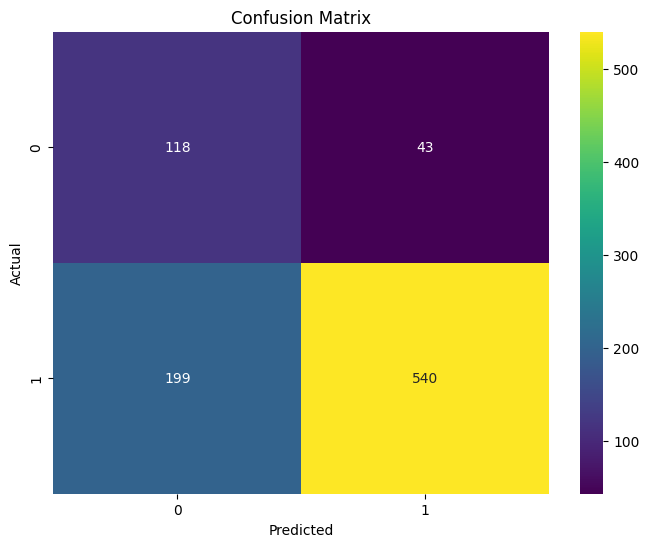

In [48]:
# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(y_val, val_predictions_labels)
plot_confusion_matrix(conf_matrix)

Como se ha visto anteriormente el modelo tiene un buen rendimiento en la predicción de la clase mayoritaria, pero comete más errores que en la clase minoritaria, como se puede observar por el mayor número de falsos positivos que negtivos.

Al igual que se ha realizado con el modelo de random forest se ajustan los hiperparametros del modelo XGBoost.

In [15]:
def objective_xgb(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'random_state': 42 
    }
    pipeline = ImbPipeline([
        ('smoteenn', SMOTE(sampling_strategy='minority')),
        ('classifier', xgb.XGBClassifier(**param))
    ])
    cv_scores = cross_val_score(pipeline, X_train_embeddings, y_train, cv=cv, scoring=f1_scorer, n_jobs=-1)
    return cv_scores.mean()

Se define el proceso de optimización de hiperparámetros para el XGBoost ooptimizandose los siguientes parámetros: 

- `n_estimators`: Número de árboles en el modelo XGBoost, variando entre 100 y 3000.
- `max_depth`: Profundidad máxima de cada árbol, con valores entre 3 y 30, que controla la capacidad del modelo para capturar relaciones complejas.
- `learning_rate`: Tasa de aprendizaje, que se ajusta entre 0.01 y 0.1, afectando la velocidad con la que el modelo ajusta los errores.
- `gamma`: Control de la complejidad de los árboles, regulando las divisiones en los nodos según su reducción en la pérdida.
- `reg_alpha` y `reg_lambda`: Parámetros de regularización L1 y L2, que ayudan a reducir el sobreajuste penalizando pesos elevados.

Se incluye la técnica SMOTE para equilibrar la clase minoritaria durante el entrenamiento y se evalúa mediante validación cruzada usando el F1-score.

In [16]:
# Create a study object, optimize the objective function, and print the best hyperparameters and score
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=10, n_jobs=-1)

print(f'XGBoost: Hyperparameters: {study_xgb.best_params}\nXGBoost: Scores: {study_xgb.best_value}')

[I 2024-09-10 10:35:16,284] A new study created in memory with name: no-name-e58c3549-4420-40c4-81b5-ba0584cb18ce
[I 2024-09-10 10:37:07,592] Trial 5 finished with value: 0.8992390606559303 and parameters: {'n_estimators': 577, 'max_depth': 20, 'learning_rate': 0.05701366943503992, 'gamma': 3.167284797444876, 'reg_alpha': 2.885886051383086, 'reg_lambda': 0.21388088576162312}. Best is trial 5 with value: 0.8992390606559303.
[I 2024-09-10 10:41:41,480] Trial 6 finished with value: 0.904868005875173 and parameters: {'n_estimators': 462, 'max_depth': 11, 'learning_rate': 0.02582928064974142, 'gamma': 2.2444907505077754, 'reg_alpha': 3.4109167886133402, 'reg_lambda': 4.063947475103205}. Best is trial 6 with value: 0.904868005875173.
[I 2024-09-10 10:43:29,384] Trial 0 finished with value: 0.9051798165674813 and parameters: {'n_estimators': 270, 'max_depth': 12, 'learning_rate': 0.04328716937399258, 'gamma': 1.2591253652674443, 'reg_alpha': 4.3144770606615, 'reg_lambda': 4.58342986600365}. B

XGBoost: Hyperparameters: {'n_estimators': 2798, 'max_depth': 21, 'learning_rate': 0.07078588069359125, 'gamma': 0.42722018536197004, 'reg_alpha': 0.6965629448025701, 'reg_lambda': 2.510740844415664}
XGBoost: Scores: 0.907135467912302


Los mejores hiperparámetros incluyen un alto número de árboles (2798) y una profundidad máxima de 21, lo que permite que el modelo capture relaciones complejas en los datos. La tasa de aprendizaje es moderadamente alta comparada con una red neuronal, lo que permite una actualización gradual de los pesos. El parámetro gamma (0.43) evita divisiones innecesarias y reduciendo la complejidad del modelo. Los valores de regularización L1 (0.70) y L2 (2.51) ayudan a prevenir el sobreajuste al penalizar pesos elevados en los árboles.

Este conjunto de hiperparámetros obtuvo un F1-score de 0.907. Se serializan los reusltados obtendos del estudio de optimización de hiperparámetros.

In [17]:
# Save the Optuna study
joblib.dump(study_xgb, MODELS_DIR / 'xgb_study.pkl')

['/Users/borja/Documents/Somniumrema/projects/ml/class_trans/models/xgb_study.pkl']

Al igual que en el caso de Random forest se visualiza al evolución del entrenamiento

In [18]:
# Generate and display visualizations
visualizations = [
    optuna.visualization.plot_optimization_history,
    optuna.visualization.plot_parallel_coordinate
]
# Show optimization paths
for viz in visualizations:
    viz(study_xgb).show()

Se observa que en los tres primeros intentos ya tiene el valor máximo objetivo el cual mantiene a lo largo del proceso de optimización aunque con distintas combinaciones de parámetros. En este caso, vlores cercanos a 0.7 en el `learning_rate` con valores entre o.5 y 1 de `gamma` y valores entre 10 y 23 en cuanto al `max_depth` conllevan obtener el mejor valor de f1. Esto unido con valores bajos de `reg_alpha` y valores medios de `reg_lambda` mejoran la capcidad predictiva dle modelo.

Se ajusta el modelo con los mejores hiperparámetros y se serializa el mismo.

In [19]:
# Train the final model with the best hyperparameters and save the trained model pipeline
joblib.dump(
    ImbPipeline([
        ('smoteenn', SMOTE(sampling_strategy='minority', random_state=42)),
        ('classifier', xgb.XGBClassifier(**study_xgb.best_params))
    ]).fit(X_train_embeddings, y_train),
    MODELS_DIR / 'xgb_model.pkl'
)

['/Users/borja/Documents/Somniumrema/projects/ml/class_trans/models/xgb_model.pkl']

Se realizan predicciones con el modelo dando probabilidades respecto a al pertenencia de clase. Se estima un umbrla para maximizar la métrica en la asignación de clases para probabilidad. 

In [50]:
# Load the trained model pipeline and predict on validation set
val_predictions_xgb = joblib.load(MODELS_DIR / 'xgb_model.pkl').predict_proba(X_val_embeddings)

In [76]:
# Define a custom threshold
threshold = 0.28

# Apply the custom threshold to convert probabilities to class labels
val_predictions_thresholded = (val_predictions_xgb >= threshold).astype(int)

# Determine the final class label based on the highest probability
val_predictions_labels = np.argmax(val_predictions_thresholded, axis=1)

In [77]:
# Print the classification report
print(classification_report(y_val, val_predictions_labels))

              precision    recall  f1-score   support

           0       0.46      0.57      0.51       161
           1       0.90      0.85      0.88       739

    accuracy                           0.80       900
   macro avg       0.68      0.71      0.69       900
weighted avg       0.82      0.80      0.81       900



XGBoost muestra un mejor manejo de la clase minoritaria, con una precisión y F1-score para esa clase (0.46 y 0.51 frente a 0.37 y 0.49), lo que significa que tiene menos problemas para identificar observaciones de la misma. Asimimso mejora las métricas respecto a la clase mayoritaria por lo que dicho modelo XGBoost es el que se llevaría a producción.

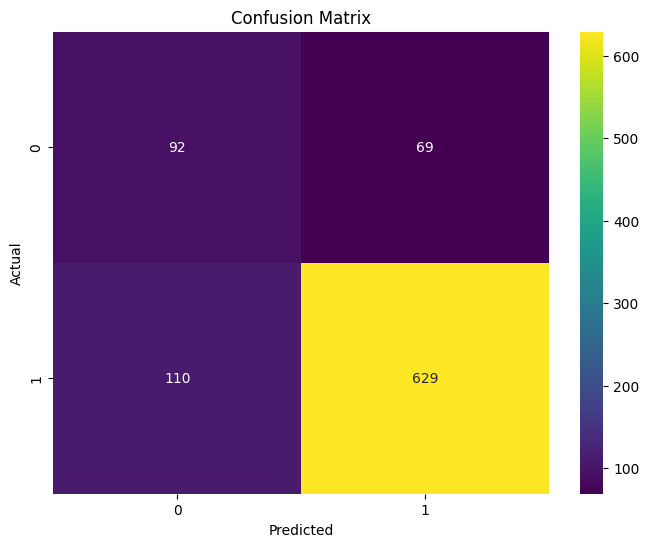

In [78]:
# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(y_val, val_predictions_labels)
plot_confusion_matrix(conf_matrix)

Aunque los falsos negativos son inferiores, los falsos positivos son algo mayores, sin embargo en su conjunto el número de observaciones no clasificadas correctamente es menor otorgando a este modelo mejores valores de f1-score. Por este motivo se conparará la red neuronal obtenida anteriormente con este modelo 

# Comparación de modelos

En la comparación de los resultados entre el modelo de red neuronal y el modelo XGBoost, podemos observar las siguientes diferencias clave:

- **Clase 0:**

La precisión del modelo de red neuronal tiene una precisión de 0.69, mientras que XGBoost alcanza 0.46. Esto indica que la red neuronal es más precisa en identificar correctamente las recomendaciones negativas mientras que XGBoost tiene más falsos positivos para esta clase. En cuanot al recall XGBoost (0.57) supera ligeramente a la red neuronal (0.52) en el para la clase 0, lo que significa que XGBoost es más eficaz en identificar correctamente las recomendaciones negativas, aunque lo hace a expensas de más falsos positivos.En cuanot a F1-Score la red neuronal tiene un mejor F1-score (0.59 vs 0.51), lo que significa que logra un mejor equilibrio entre precisión y recall en esta clase.

- **Clase 1 ("Recommended"):**

En cuanto a la precisión de ambos modelos, lo dos presentan valores similares para la clase mayoritaria con un 0.90 en ambos casos, lo que muestra que ambos son igualmente buenos en identificar correctamente las reseñas positivas. La red neuronal tiene un recall más alto (0.95 frente a 0.85 para XGBoost), lo que significa que es mejor identificando la mayoría de las recomemndaciones posirtivas frente a XGBoost. La red neuronal tiene un F1-score superior (0.92 frente a 0.88), lo que indica un mejor rendimiento general en la clase mayoritaria.

De forma global la red neuronal tiene una mayor accuracy general (0.87 frente a 0.80 en XGBoost), lo que refleja un mejor rendimiento en la clasificación global. Adicionalmente supera también supera a XGBoost en el promedio macro (0.76 frente a 0.69), lo que indica que maneja mejor ambas clases de manera equilibrada, mientras que XGBoost tiende a penalizar más a la clase minoritaria. Lo mismo ocurre en el caso eel wieghted average (0.86 frente a 0.81).

**Elección del modelo:**

El modelo de red neuronal muestra un rendimiento superior, particularmente en el manejo de la clase mayoritaria "Recommended" con un mejor recall y F1-score, lo que lo convierte en una mejor opción para este problema si el objetivo es minimizar errores tanto en la clase mayoritaria como en la minoritaria. Sin embargo, si se necesita un mejor balance en la identificación de la clase minoritaria, XGBoost puede ser útil dado su mayor recall en la clase negativa, aunque sacrifica precisión global.

En este caso se opta por la red neuronal al ser la opción más sólida para este caso, ya que maneja mejor el balance entre precisión y recall en ambas clases, mientras que XGBoost tiende a ser menos preciso en la clase minoritaria.

Al haberse elegido XGBosst entre ambos modelos, se procede a predecir las recomendaciones con el mismo. Se procede a cargar y hacer los embeddings para los datos contenidos en new_data.txt

In [9]:
# Load the new data and apply the cleaning function
new_data_embeddings = model.encode(new_data['cleaned_review'].tolist())

# Load the trained model pipeline and predict on validation set
val_predictions_xgb = joblib.load(MODELS_DIR / 'xgb_model.pkl').predict_proba(new_data_embeddings)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Se utiliza el mismo threshold utilizado con el set de entrenamiento y validación

In [13]:
# Define a custom threshold
threshold = 0.28

# Apply the custom threshold to convert probabilities to class labels
val_predictions_thresholded = (val_predictions_xgb >= threshold).astype(int)

# Determine the final class label based on the highest probability
val_predictions_labels = np.argmax(val_predictions_thresholded, axis=1)

Se salvan las recomendaciones en fichero txt

In [17]:
# Add predictions to the DataFrame
new_data['predictions'] = val_predictions_labels

# Prepare the new dataset by dropping the 'cleaned_review' column
new_data_prepared = new_data.drop(columns=['cleaned_review'])

# Save the new dataset with predictions
new_data_prepared.to_csv(DATA_DIR / 'new_data_w_preds_xgboost.txt', index=False, sep='\t')

print(f"New data with predictions saved to {DATA_DIR / 'new_data_w_preds_xgboost.txt'}")

New data with predictions saved to /Users/borja/Documents/Somniumrema/projects/ml/class_trans/data/new_data_w_preds_xgboost.txt
